In [1]:
import math
import numpy as np
from torch import nn
import torch.nn.functional as F
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import itertools
%matplotlib inline

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Exploration factor
epsilon = 0.1

In [4]:
# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(object):
    def __init__(self, maze, rat=(0,0)):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self.walls = 1 - self._maze
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        self.free_cells.remove(self.target)
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        self.reset(rat)
        self.coverage = np.zeros(self._maze.shape)

    def reset(self, rat):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        self.state = (row, col, 'start')
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state

        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.add((rat_row, rat_col))  # mark visited cell

        valid_actions = self.valid_actions()

        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:                  # invalid action, no change in rat position
            mode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)
        self.coverage[nrow][ncol] += 1

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 1.0
        if mode == 'blocked':
            return 0
        if (rat_row, rat_col) in self.visited:
            return 0.
        if mode == 'invalid':
            return 0.
        if mode == 'valid':
            return 0.

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        canvas = 2 * (self._maze - canvas)
        envstate = np.stack([self._maze, self.walls, canvas], axis=0)
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'

        return 'not_over'

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)

        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)

        return actions

In [5]:
from IPython.display import clear_output
import time
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [6]:
class NoisyLinear(nn.Module):
    """Noisy linear module for NoisyNet."""
    def __init__(self, in_features: int, out_features: int, std_init: float = 0.5):
        super(NoisyLinear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.Tensor(out_features, in_features))
        self.register_buffer("weight_epsilon", torch.Tensor(out_features, in_features))

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.out_features))

    def reset_noise(self):
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )

    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        x = torch.randn(size)
        return x.sign().mul(x.abs().sqrt())


class Network(nn.Module):
    def __init__(self, input_size, kernel_size, num_filters, out_features, device=device):
        super(Network, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, num_filters, kernel_size),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(int(num_filters*(input_size[0]-kernel_size+1)*(input_size[1]-kernel_size+1)/4), 32),
            nn.PReLU(),
            NoisyLinear(32, out_features)
        )
        self.to(device)

    def forward(self, x):
        return self.net(x)

    def act(self, obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32).to(device)
        q_values = self.forward(obs_t.unsqueeze(0))
        max_q_index = torch.argmax(q_values, dim=1)[0]
        action = max_q_index.detach().item()
        return action

class DQNAgent():
    def __init__(self, env, epsilon_start, epsilon_end, epsilon_decay, gamma):
        input_size = env.maze.shape
        out_features = 4
        kernel_size = 3
        num_filters = 6
        self.num_actions = out_features
        self.gamma = gamma
        self.targets = None
        self.action_qvalues = None
        self.online_net = Network(input_size, kernel_size, num_filters, out_features)
        self.target_net = Network(input_size, kernel_size, num_filters, out_features)
        self.target_net.load_state_dict(self.online_net.state_dict())
        self.optimizer = torch.optim.Adam(self.online_net.parameters(), lr=5e-4)
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.counter = 1

    def choose_action(self, time, obs):
        epsilon = np.interp(time, [0, self.epsilon_decay], [self.epsilon_start, self.epsilon_end])
        rnd_sample = random.random()
        if rnd_sample <= epsilon:
            action = random.randrange(self.num_actions)
        else:
            action = self.online_net.act(obs)

        return action

    def calculate_target(self, new_obses_t, rews_t, dones_t):
        target_qvalues = self.target_net(new_obses_t)
        max_target_qvalues = target_qvalues.max(dim=1, keepdim=True)[0]

        self.targets = rews_t + self.gamma * (1 - dones_t) * max_target_qvalues

    def calculate_action_qvalues(self, obses_t, actions_t):
        q_values = self.online_net(obses_t)
        self.action_qvalues = torch.gather(input=q_values, dim=1, index=actions_t)

    def optimize_network(self):
        loss = nn.functional.smooth_l1_loss(self.action_qvalues, self.targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.online_net.state_dict())

In [7]:
GAMMA = 0.9
BATCH_SIZE = 32
BUFFER_SIZE = 100000
MIN_REPLAY_SIZE = 1000
EPSILON_START = 0.001
EPSILON_END = 0.001
EPSILON_DECAY = 5000
TARGET_UPDATE_FREQ = 200

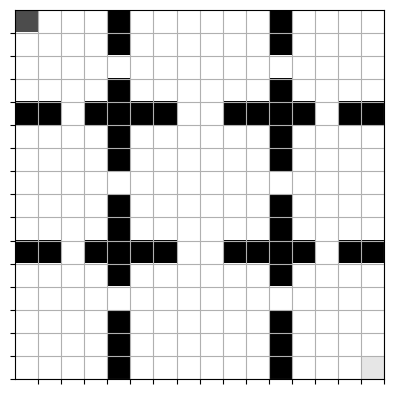

In [8]:
maze = [
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  1., 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  1., 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
]
env = Qmaze(maze)
show(env)

In [ ]:
avg_returns = []
episodes = []
current_coverage = []
coverage_steps = [200, 500, 1000, 50000]
# prefix = f"{sigma}_{rate}_"

# Noise defined
for k in range(10):
    current_return = []

    replay_buffer = deque(maxlen=BUFFER_SIZE)
    rew_buffer = []
    temp_episodes = []

    rat_cell = (0, 0)
    env = Qmaze(maze)
    env.reset(rat_cell)
    obs = env.observe()

    agent = DQNAgent(env, EPSILON_START, EPSILON_END, EPSILON_DECAY, GAMMA)
    cnt = 0
    coverage_counter = 0
    episode = 0
    for step in itertools.count():
        agent.counter += 1
        action = agent.choose_action(step, obs)

        new_obs, rew, done = env.act(action)
        Transition = (obs, action, rew, done, new_obs)
        replay_buffer.append(Transition)
        obs = new_obs


        if done != 'not_over':
            rat_cell = (0,0)
            env.reset(rat_cell)
            obs = env.observe()
            rew_buffer.append(GAMMA**(cnt))
            episode += 1
            cnt = 0

        if len(replay_buffer) > BATCH_SIZE:
            transitions = random.sample(replay_buffer, BATCH_SIZE)
            obses = np.asarray([t[0] for t in transitions])
            actions = np.asarray([t[1] for t in transitions])
            rews = np.asarray([t[2] for t in transitions])
            dones = np.asarray([t[3] for t in transitions])
            new_obses = np.asarray([t[4] for t in transitions])

            converted_dones = [done != 'not_over' for done in dones]

            obses_t = torch.as_tensor(obses, dtype=torch.float32).to(device)
            actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1).to(device)
            rews_t = torch.as_tensor(rews, dtype=torch.float32).unsqueeze(-1).to(device)
            dones_t = torch.as_tensor(converted_dones, dtype=torch.float32).unsqueeze(-1).to(device)
            new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32).to(device)

            # Calculate noise
            # var = sigma / np.ceil (agent.counter / rate)
            var = 0

            agent.calculate_target(new_obses_t, rews_t, dones_t)
            agent.calculate_action_qvalues(obses_t, actions_t)
            agent.optimize_network()

        if step % TARGET_UPDATE_FREQ == 0:
            agent.update_target_network()

        if step in coverage_steps:
            if k == 0:
                current_coverage.append(np.copy(env.coverage.reshape(1, env.coverage.shape[0], env.coverage.shape[1])))
            else:
                current_coverage[coverage_counter] = np.concatenate(
                    [current_coverage[coverage_counter], env.coverage.reshape(1, env.coverage.shape[0], env.coverage.shape[1])], axis=0)

            coverage_counter += 1

        if step > 100000:
            episodes.append(np.copy(temp_episodes))
            avg_returns.append(np.copy(rew_buffer))
            break
        cnt += 1

        if step % 5000 == 0:
            temp_episodes.append(episode)

            print(f"trained {k} times - ep num = {episode}")

min_length = np.min([len(array) for array in avg_returns])
np.save("episodes.npy", np.mean(episodes, axis=0))
np.save("score.npy", np.mean([array[:min_length] for array in avg_returns], axis=0))
for s in range(len(coverage_steps)):
    np.save(f"heat_{coverage_steps[s]}.npy", np.mean(current_coverage[s], axis=0))

trained 0 times - ep num = 0
trained 0 times - ep num = 0
trained 0 times - ep num = 0
trained 0 times - ep num = 0
trained 0 times - ep num = 0
trained 0 times - ep num = 0
trained 0 times - ep num = 0
trained 0 times - ep num = 0
trained 0 times - ep num = 0
trained 0 times - ep num = 0
trained 0 times - ep num = 0
trained 0 times - ep num = 1
trained 0 times - ep num = 2
trained 0 times - ep num = 2
trained 0 times - ep num = 3
trained 0 times - ep num = 4
trained 0 times - ep num = 5
trained 0 times - ep num = 6
trained 0 times - ep num = 12
trained 0 times - ep num = 123
trained 0 times - ep num = 288
trained 1 times - ep num = 0
trained 1 times - ep num = 0
trained 1 times - ep num = 0
trained 1 times - ep num = 0
trained 1 times - ep num = 0
trained 1 times - ep num = 0
trained 1 times - ep num = 0
trained 1 times - ep num = 0
trained 1 times - ep num = 0
trained 1 times - ep num = 0
trained 1 times - ep num = 0
trained 1 times - ep num = 0
trained 1 times - ep num = 0


In [ ]:
plt.plot(rew_buffer)
plt.show()
plt.imshow(np.mean(current_coverage[1], axis=0)[2:][:], cmap='hot', interpolation='nearest')

In [ ]:
env.reset((0, 0))
done = 'not_over'
while done == 'not_over':
    action = agent.choose_action(step, obs)

    new_obs, rew, done = env.act(action)

    step += 1
    obs = new_obs
    plt.figure()
    show(env)
print(step)